In [1]:
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# Swinging Sticks Runner
> Train and analyze performance on swinging sticks dataset

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax

from copy import deepcopy
import logging
from tqdm.notebook import trange
from functools import partial
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from jaxDiversity.dataloading import SwingingSticksDataset, NumpyLoader
from jaxDiversity.utilclasses import InnerConfig, OuterConfig
from jaxDiversity.mlp import (
    mlp_afunc,
    MultiActMLP,
    init_linear_weight,
    xavier_normal_init,
    xavier_uniform_init,
)
from jaxDiversity.hnn import compute_loss as compute_loss_hnn
from jaxDiversity.loops import inner_opt, outer_opt

In [4]:
sns.set_theme(
    context="paper",
    style="white",
    palette="colorblind",
    font_scale=1,
    color_codes=True,
    rc={"text.usetex": True},
)

In [5]:
# Configure the logger
logging.basicConfig(level=logging.INFO)

In [6]:
# run on cpu
# jax.config.update('jax_platform_name', 'cpu')
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:jax backend: gpu


### Test dataset access

In [7]:
# | test
TEST_TRAIN_SPLIT = 0.8
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(data_path, TEST_TRAIN_SPLIT, train=True)
test_dataset = SwingingSticksDataset(data_path, TEST_TRAIN_SPLIT, train=False)

train_dataloader = NumpyLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

assert x.shape == (8, 4)
assert y.shape == (8, 4)

## inner loop testing

INFO:root:HNN NN inner loop test
INFO:root:Epoch 000 | Train Loss: 8.7916e-02 | Test Loss: 9.1292e-02 | Grad Norm: 1.9850e-01
INFO:root:Epoch 001 | Train Loss: 6.0811e-02 | Test Loss: 7.0866e-02 | Grad Norm: 7.4733e-01
INFO:root:Epoch 002 | Train Loss: 6.2485e-02 | Test Loss: 5.7384e-02 | Grad Norm: 4.4436e-01
INFO:root:Epoch 003 | Train Loss: 4.5993e-02 | Test Loss: 4.3788e-02 | Grad Norm: 2.7678e-01
INFO:root:Epoch 004 | Train Loss: 3.0517e-02 | Test Loss: 2.5910e-02 | Grad Norm: 6.7557e-01
INFO:root:Epoch 005 | Train Loss: 2.9714e-02 | Test Loss: 2.4760e-02 | Grad Norm: 5.3238e-01
INFO:root:Epoch 006 | Train Loss: 2.3131e-02 | Test Loss: 2.7887e-02 | Grad Norm: 9.0932e-01
INFO:root:Epoch 007 | Train Loss: 2.6087e-02 | Test Loss: 2.6800e-02 | Grad Norm: 3.3076e-01
INFO:root:Epoch 008 | Train Loss: 3.1401e-02 | Test Loss: 2.4953e-02 | Grad Norm: 8.5811e-01
INFO:root:Epoch 009 | Train Loss: 2.4164e-02 | Test Loss: 2.1315e-02 | Grad Norm: 7.4691e-01
INFO:root:Epoch 010 | Train Loss: 1.7

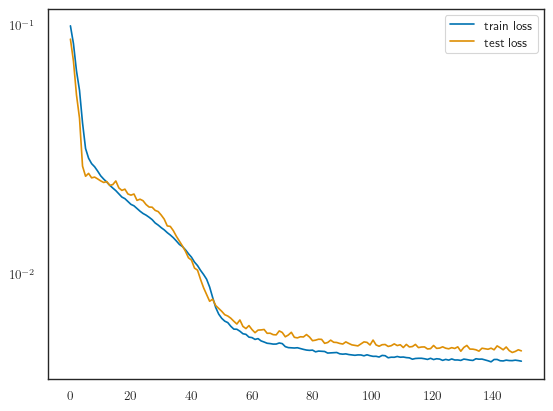

In [8]:
# | test
# test inner_opt
dev_inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=1,
    hidden_layer_sizes=[100, 100],
    batch_size=128,
    epochs=150,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
key = jax.random.PRNGKey(dev_inner_config.seed)
model_key, init_key = jax.random.split(key)
afuncs = [jnp.tanh, jnp.tanh]
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(
    data_path, dev_inner_config.test_train_split, train=True
)
test_dataset = SwingingSticksDataset(
    data_path, dev_inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)

# schedule = optax.warmup_cosine_decay_schedule(
#   init_value=1e-2,
#   peak_value=1e-1,
#   warmup_steps=2,
#   decay_steps=8,
#   end_value=1e-04,
# )

# schedule = optax.cosine_decay_schedule(init_value = 1e-2, decay_steps=10, alpha=0.0, exponent=1.0)
schedule = optax.exponential_decay(
    init_value=1e-2,
    transition_steps=2,
    decay_rate=0.5,
    transition_begin=0,
    staircase=False,
    end_value=1e-4,
)
# schedule = optax.cosine_onecycle_schedule(2, 0.1)

opt = optax.chain(
    optax.clip(1.0),
    optax.rmsprop(
        learning_rate=schedule,
        momentum=dev_inner_config.mu,
        decay=dev_inner_config.l2_reg,
    ),
    # optax.adabelief(learning_rate=schedule)
)

# opt = optax.rmsprop(learning_rate=dev_inner_config.lr, momentum=dev_inner_config.mu, decay=dev_inner_config.l2_reg)
model = MultiActMLP(
    dev_inner_config.input_dim,
    dev_inner_config.output_dim,
    dev_inner_config.hidden_layer_sizes,
    model_key,
    bias=True,
)
model = init_linear_weight(model, xavier_normal_init, init_key)
logging.info("HNN NN inner loop test")
baselineNN, opt_state, inner_results = inner_opt(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    afuncs=afuncs,
    opt=opt,
    loss_fn=compute_loss_hnn,
    config=dev_inner_config,
    training=True,
    verbose=True,
)

# plot inner results
train_loss = inner_results.train_loss.reshape(dev_inner_config.epochs, -1).mean(axis=1)
test_loss = inner_results.test_loss.reshape(dev_inner_config.epochs, -1).mean(axis=1)
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.yscale("log")
plt.legend()
plt.show()

### Run the experiments

In [9]:
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=1,
    hidden_layer_sizes=[100, 100],
    batch_size=64,
    epochs=5,
    lr=1e-3,
    mu=0.6,
    n_fns=1,
    l2_reg=1e-1,
    seed=42,
    base_act="tanh",
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[50],
    batch_size=1,
    steps=25,
    print_every=1,
    lr=1e-3,
    mu=0.9,
    seed=24,
)
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(
    data_path, inner_config.test_train_split, train=True
)
test_dataset = SwingingSticksDataset(
    data_path, inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
description = f"HNN_kaiming_scheduler_tanh_inner_epochs_{inner_config.epochs}_batch_{inner_config.batch_size}_outer_{outer_config.steps}_lr_{inner_config.lr}_n_{inner_config.n_fns}_seed_{inner_config.seed}"

# schedule = optax.exponential_decay(init_value=inner_config.lr*10, transition_steps=1, decay_rate=0.1, transition_begin=0, staircase=False, end_value=inner_config.lr*0.1)

# opt = optax.chain(
#   optax.clip(1.0),
#   optax.rmsprop(learning_rate=schedule, momentum=inner_config.mu, decay=inner_config.l2_reg),
# )
schedule = optax.exponential_decay(
    init_value=1e-2,
    transition_steps=2,
    decay_rate=0.5,
    transition_begin=0,
    staircase=False,
    end_value=1e-4,
)

opt = optax.chain(
    optax.clip(1.0),
    optax.rmsprop(
        learning_rate=schedule,
        momentum=dev_inner_config.mu,
        decay=dev_inner_config.l2_reg,
    ),
)

outer_schedule = optax.exponential_decay(
    init_value=1e-2,
    transition_steps=2,
    decay_rate=0.5,
    transition_begin=0,
    staircase=False,
    end_value=1e-4,
)
# outer_schedule = optax.warmup_cosine_decay_schedule(outer_config.lr/10, outer_config.lr*10, 25, outer_config.steps, end_value=0.0, exponent=1.0)

meta_opt = optax.chain(
    optax.clip(1.0),
    optax.rmsprop(learning_rate=outer_schedule, momentum=outer_config.mu),
)


# create folder to save output if it does not exist
save_path = f"../output/SwingingSticks/{description}"
fig_path = f"../figures/SwingingSticks/{description}"
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

logging.info("Hamiltonian NN SwingingSticks dataset")
HNN_acts, HNN_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_hnn,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=save_path,
)

INFO:root:Hamiltonian NN SwingingSticks dataset


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 5.0832e-02 | Test Loss: 5.4642e-02 | Grad Norm: 8.4637e-01
INFO:root:Step 001 | Train Loss: 9.9025e-02 | Test Loss: 9.2924e-02 | Grad Norm: 4.9423e-01
INFO:root:Step 002 | Train Loss: 8.6805e-02 | Test Loss: 8.6996e-02 | Grad Norm: 4.3472e-01
INFO:root:Step 003 | Train Loss: 9.9191e-02 | Test Loss: 1.3496e-01 | Grad Norm: 2.0221e-01
INFO:root:Step 004 | Train Loss: 1.6189e-01 | Test Loss: 2.3638e-01 | Grad Norm: 4.4618e-01
INFO:root:Step 005 | Train Loss: 1.9550e-01 | Test Loss: 5.9375e-01 | Grad Norm: 7.1504e-01
INFO:root:Step 006 | Train Loss: 3.2434e-01 | Test Loss: 5.9709e-01 | Grad Norm: 1.7330e+00
INFO:root:Step 007 | Train Loss: 5.6228e-01 | Test Loss: 1.2630e+00 | Grad Norm: 2.9200e+00
INFO:root:Step 008 | Train Loss: 2.7332e-01 | Test Loss: 7.2662e-01 | Grad Norm: 1.4882e+00
INFO:root:Step 009 | Train Loss: 3.6929e-01 | Test Loss: 8.3851e-01 | Grad Norm: 4.3746e+00
INFO:root:Step 010 | Train Loss: 5.1080e-01 | Test Loss: 9.1211e-01 | Grad Norm:

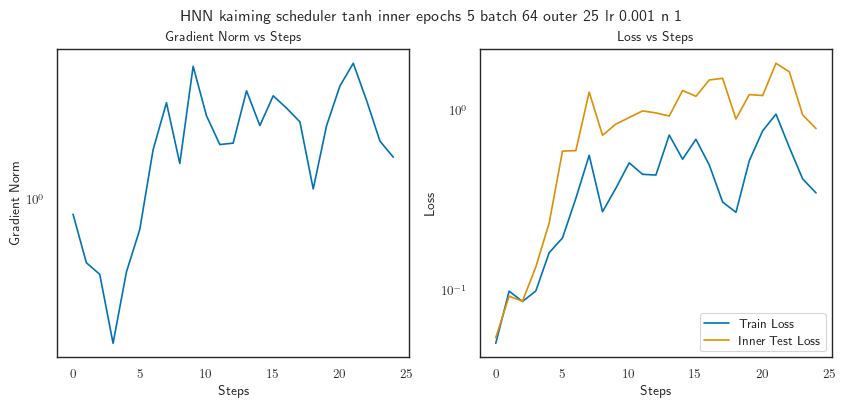

In [10]:
# plot HNN stats

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(HNN_stats.grad_norm)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Gradient Norm")
# make axis y log scale
ax[0].set_yscale("log")
ax[0].set_title("Gradient Norm vs Steps")

ax[1].plot(HNN_stats.train_loss, label="Train Loss")
ax[1].plot(HNN_stats.inner_test_loss, label="Inner Test Loss")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title("Loss vs Steps")
ax[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/stats.png")

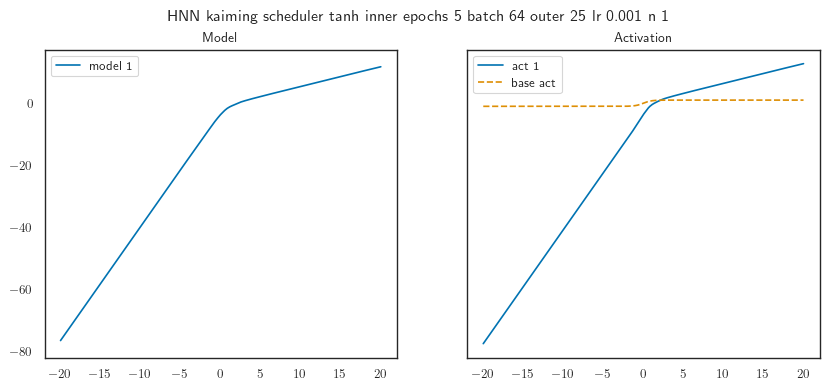

In [11]:
if inner_config.base_act == "sin":
    base_act = jnp.sin
elif inner_config.base_act == "tanh":
    base_act = jnp.tanh
elif inner_config.base_act == "relu":
    base_act = jnp.relu
x = jnp.linspace(-20, 20, 1000).reshape(-1, 1)
model_output_arrays = []
act_arrays = []
for HNN_act in HNN_acts:
    model_output_arrays.append(jax.vmap(HNN_act)(x))
    act_arrays.append(mlp_afunc(x, HNN_act, base_act))


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
for i, (model, act) in enumerate(zip(model_output_arrays, act_arrays)):
    axs[0].plot(x, model, label=f"model {i+1}")
    axs[1].plot(x, act, label=f"act {i+1}")

axs[1].plot(x, base_act(x), "--", label="base act")

axs[0].set_title("Model")
axs[1].set_title("Activation")
axs[0].legend()
axs[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/activations.png")

In [12]:
### Train inner loop for large epochs and multiple runs
runs = 10
config = deepcopy(inner_config)
config.epochs = 5
config.seed = 0
opt = optax.rmsprop(learning_rate=config.lr, momentum=config.mu, decay=config.l2_reg)


afuncs = [
    partial(mlp_afunc, model=outer_model, base_act=base_act) for outer_model in HNN_acts
]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 1.4863e+00 test loss: 1.2202e+00
INFO:root:Run 002 train loss: 7.2432e-01 test loss: 8.1747e-01


TypeError: Cannot interpret 'Array([[[-2.3849487e-02,  1.1645401e+00, -4.6619549e+00, ...,
          1.2754229e+01, -3.5183768e+00, -6.8968167e+00],
        [-1.1498545e-01,  1.2534369e+00, -6.5154967e+00, ...,
          1.8370180e+01, -5.2076535e+00, -9.9435711e+00],
        [-5.4634392e-01,  1.6741974e+00, -1.5288554e+01, ...,
          4.4951221e+01, -1.3203224e+01, -2.4364265e+01],
        ...,
        [-9.7563416e-03,  1.1507932e+00, -4.3753252e+00, ...,
          1.1885785e+01, -3.2571490e+00, -6.4256701e+00],
        [-3.1547654e-01,  1.4490023e+00, -1.0593125e+01, ...,
          3.0724781e+01, -8.9239140e+00, -1.6646164e+01],
        [ 9.7086951e-02,  1.0465748e+00, -2.2023244e+00, ...,
          5.3019209e+00, -1.2767241e+00, -2.8538046e+00]],

       [[ 1.4069498e-02,  1.1275527e+00, -3.8907504e+00, ...,
          1.0417597e+01, -2.8155181e+00, -5.6291513e+00],
        [-1.4430971e-01,  1.2820407e+00, -7.1118999e+00, ...,
          2.0177193e+01, -5.7512021e+00, -1.0923907e+01],
        [-4.7403473e-01,  1.6036649e+00, -1.3817914e+01, ...,
          4.0495403e+01, -1.1862915e+01, -2.1946903e+01],
        ...,
        [-2.3126259e-02,  1.1638346e+00, -4.6472454e+00, ...,
          1.2709662e+01, -3.5049710e+00, -6.8726382e+00],
        [-2.8370690e-01,  1.4180131e+00, -9.9469881e+00, ...,
          2.8767082e+01, -8.3350391e+00, -1.5584078e+01],
        [ 1.3157803e-01,  1.0129312e+00, -1.5008378e+00, ...,
          3.1765218e+00, -6.3740468e-01, -1.7007375e+00]],

       [[-3.4948111e-01,  1.4821713e+00, -1.1284718e+01, ...,
          3.2820202e+01, -9.5542164e+00, -1.7782969e+01],
        [-9.3047902e-02,  1.2320384e+00, -6.0693264e+00, ...,
          1.7018353e+01, -4.8010240e+00, -9.2101803e+00],
        [-1.1655720e+00,  2.2782121e+00, -2.7882545e+01, ...,
          8.3109108e+01, -2.4681108e+01, -4.5065609e+01],
        ...,
        [-1.8850490e-02,  1.1596639e+00, -4.5602841e+00, ...,
          1.2446182e+01, -3.4257162e+00, -6.7296953e+00],
        [-6.5744257e-01,  1.7825665e+00, -1.7548100e+01, ...,
          5.1797306e+01, -1.5262525e+01, -2.8078390e+01],
        [-2.0260395e-01,  1.3389027e+00, -8.2974997e+00, ...,
          2.3769381e+01, -6.8317318e+00, -1.2872735e+01]],

       ...,

       [[-2.2265919e-01,  1.3584653e+00, -8.7053871e+00, ...,
          2.5005219e+01, -7.2034717e+00, -1.3543200e+01],
        [-1.4550531e+00,  2.5605810e+00, -3.3770069e+01, ...,
          1.0094742e+02, -3.0046869e+01, -5.4743217e+01],
        [-9.0810493e-02,  1.2298559e+00, -6.0238214e+00, ...,
          1.6880480e+01, -4.7595520e+00, -9.1353817e+00],
        ...,
        [-7.9947308e-02,  1.2192596e+00, -5.8028836e+00, ...,
          1.6211071e+01, -4.5581942e+00, -8.7722158e+00],
        [ 2.9251689e-01,  8.5594642e-01,  1.7723696e+00, ...,
         -6.7408018e+00,  2.3457239e+00,  3.6795900e+00],
        [ 4.6040602e-02,  1.0963671e+00, -3.2405157e+00, ...,
          8.4474831e+00, -2.2229085e+00, -4.5603294e+00]],

       [[-1.9413151e-01,  1.3306385e+00, -8.1251850e+00, ...,
          2.3247293e+01, -6.6746883e+00, -1.2589494e+01],
        [-1.4435359e+00,  2.5493467e+00, -3.3535831e+01, ...,
          1.0023771e+02, -2.9833387e+01, -5.4358185e+01],
        [-6.7473873e-02,  1.2070926e+00, -5.5491967e+00, ...,
          1.5442437e+01, -4.3269892e+00, -8.3552179e+00],
        ...,
        [-9.9075094e-02,  1.2379174e+00, -6.1919088e+00, ...,
          1.7389757e+01, -4.9127426e+00, -9.4116745e+00],
        [ 3.0653214e-01,  8.4227550e-01,  2.0574150e+00, ...,
         -7.6044464e+00,  2.6055081e+00,  4.1481323e+00],
        [ 1.2616843e-02,  1.1289697e+00, -3.9202950e+00, ...,
          1.0507112e+01, -2.8424442e+00, -5.6777148e+00]],

       [[-1.4296256e-01,  1.2807267e+00, -7.0845013e+00, ...,
          2.0094177e+01, -5.7262316e+00, -1.0878871e+01],
        [-1.2936469e+00,  2.4031403e+00, -3.0487358e+01, ...,
          9.1001297e+01, -2.7055077e+01, -4.9347263e+01],
        [-1.0216518e-01,  1.2409316e+00, -6.2547555e+00, ...,
          1.7580173e+01, -4.9700198e+00, -9.5149784e+00],
        ...,
        [-9.1438279e-02,  1.2304683e+00, -6.0365896e+00, ...,
          1.6919165e+01, -4.7711883e+00, -9.1563692e+00],
        [ 2.2974212e-01,  9.1717887e-01,  4.9564362e-01, ...,
         -2.8725152e+00,  1.1821443e+00,  1.5809746e+00],
        [ 6.7170613e-02,  1.0757562e+00, -2.8107693e+00, ...,
          7.1454163e+00, -1.8312472e+00, -3.8539343e+00]]], dtype=float32)' as a data type

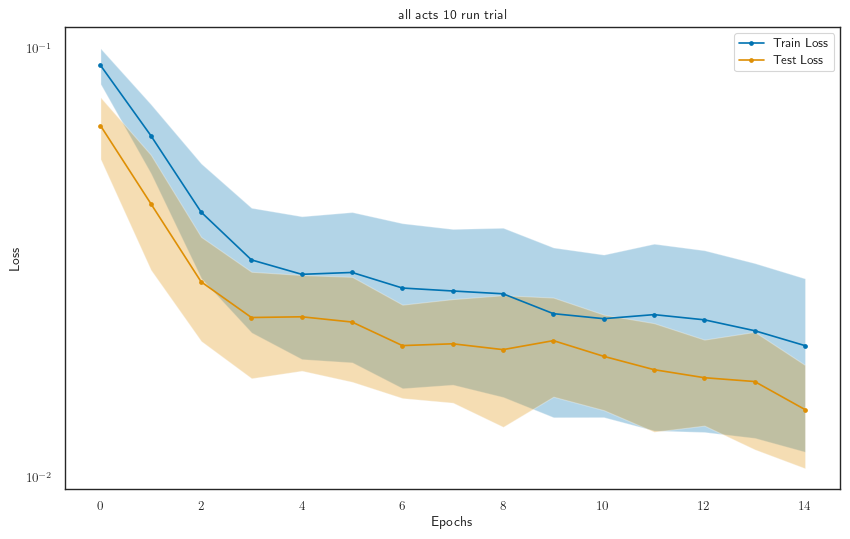

In [ ]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

all_acts = [train_losses, test_losses]

train_mean = all_acts[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = all_acts[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = all_acts[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = all_acts[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"all acts {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/all_acts.png")

In [ ]:
### Train inner loop for large epochs and multiple runs for act 1
config.seed = 0
opt = optax.rmsprop(learning_rate=config.lr, momentum=config.mu, decay=config.l2_reg)
afuncs = [partial(mlp_afunc, model=HNN_acts[0], base_act=base_act)]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 6.3661e-02 test loss: 6.1190e-02
INFO:root:Run 002 train loss: 4.7208e-02 test loss: 3.7471e-02
INFO:root:Run 003 train loss: 1.3151e-01 test loss: 8.0879e-02
INFO:root:Run 004 train loss: 9.3677e-02 test loss: 1.0212e-01
INFO:root:Run 005 train loss: 2.7822e-02 test loss: 3.6309e-02
INFO:root:Run 006 train loss: 9.1661e-02 test loss: 9.5658e-02
INFO:root:Run 007 train loss: 9.4191e-02 test loss: 8.9169e-02
INFO:root:Run 008 train loss: 5.5115e-02 test loss: 8.5014e-02
INFO:root:Run 009 train loss: 3.6169e-02 test loss: 4.2293e-02
INFO:root:Run 010 train loss: 5.2473e-02 test loss: 4.9124e-02


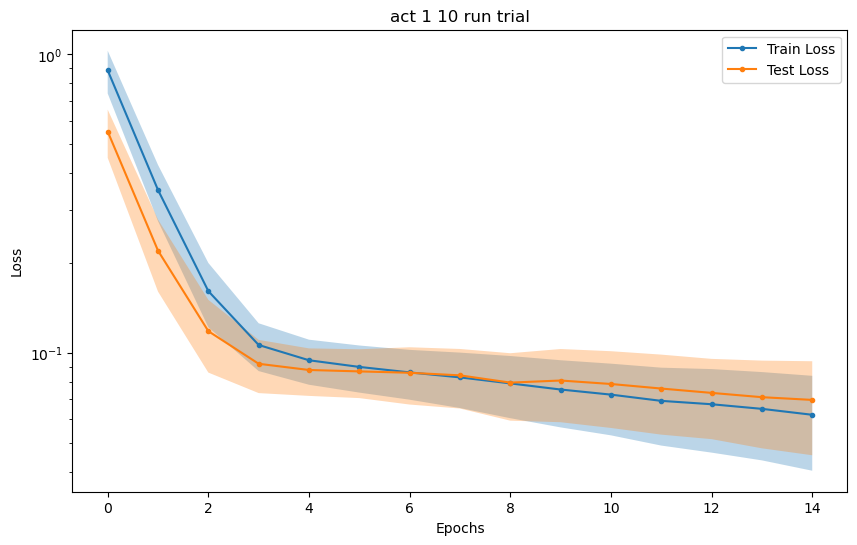

In [ ]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_1 = [train_losses, test_losses]

train_mean = act_1[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_1[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_1[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_1[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 1 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_1.png")

In [ ]:
### Train inner loop for large epochs and multiple runs for act 2
config.seed = 0
opt = optax.rmsprop(learning_rate=config.lr, momentum=config.mu, decay=config.l2_reg)
afuncs = [partial(mlp_afunc, model=HNN_acts[1], base_act=base_act)]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 7.3132e-02 test loss: 1.0823e-01
INFO:root:Run 002 train loss: 4.3989e-02 test loss: 4.4159e-02
INFO:root:Run 003 train loss: 3.3981e-02 test loss: 3.3338e-02
INFO:root:Run 004 train loss: 7.8553e-02 test loss: 1.1564e-01
INFO:root:Run 005 train loss: 3.9168e-02 test loss: 4.6139e-02
INFO:root:Run 006 train loss: 6.8813e-02 test loss: 1.4319e-01
INFO:root:Run 007 train loss: 9.3607e-02 test loss: 8.5660e-02
INFO:root:Run 008 train loss: 7.2250e-02 test loss: 1.1260e-01
INFO:root:Run 009 train loss: 3.9374e-02 test loss: 4.5144e-02
INFO:root:Run 010 train loss: 1.5561e-02 test loss: 1.3053e-02


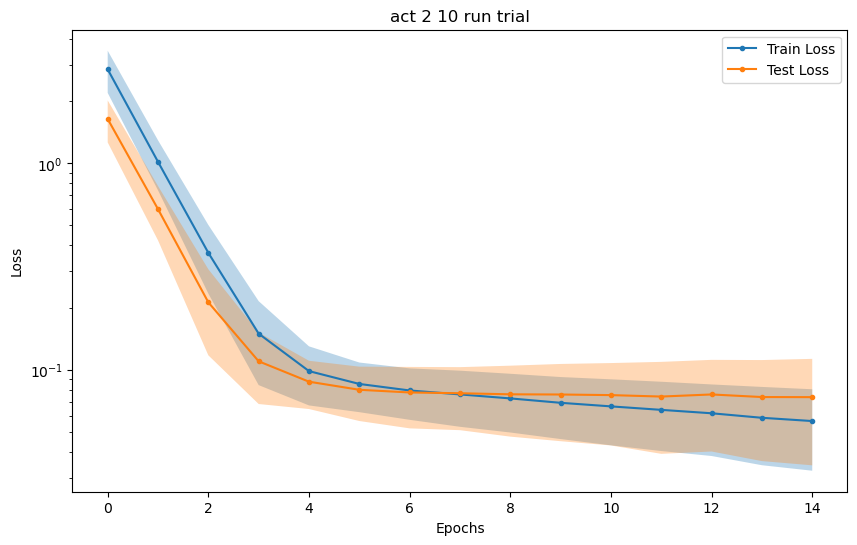

In [ ]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_2 = [train_losses, test_losses]

train_mean = act_2[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_2[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_2[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_2[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 2 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_2.png")

In [ ]:
### Train inner loop for large epochs and multiple runs for sine
config.seed = 0
opt = optax.rmsprop(learning_rate=config.lr, momentum=config.mu, decay=config.l2_reg)
afuncs = [base_act]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 9.1752e-03 test loss: 1.2331e-02
INFO:root:Run 002 train loss: 7.9736e-03 test loss: 7.2467e-03
INFO:root:Run 003 train loss: 6.8547e-03 test loss: 7.4535e-03
INFO:root:Run 004 train loss: 1.0180e-02 test loss: 9.5718e-03
INFO:root:Run 005 train loss: 6.5203e-03 test loss: 8.0850e-03
INFO:root:Run 006 train loss: 1.4688e-02 test loss: 1.8262e-02
INFO:root:Run 007 train loss: 1.2866e-02 test loss: 6.7912e-03
INFO:root:Run 008 train loss: 7.5274e-03 test loss: 7.3023e-03
INFO:root:Run 009 train loss: 1.6557e-02 test loss: 1.5440e-02
INFO:root:Run 010 train loss: 7.7239e-03 test loss: 8.9834e-03


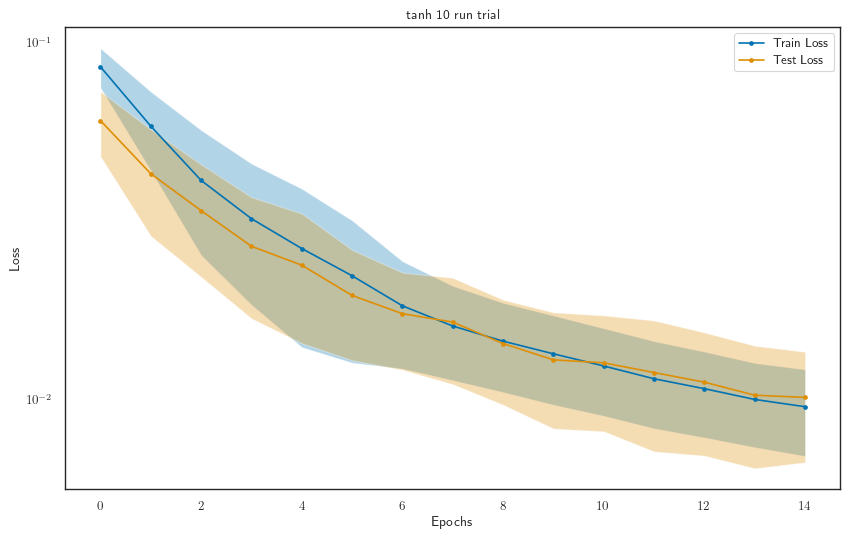

In [ ]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_sin = [train_losses, test_losses]

train_mean = act_sin[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_sin[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_sin[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_sin[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"{inner_config.base_act} {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_sin.png")

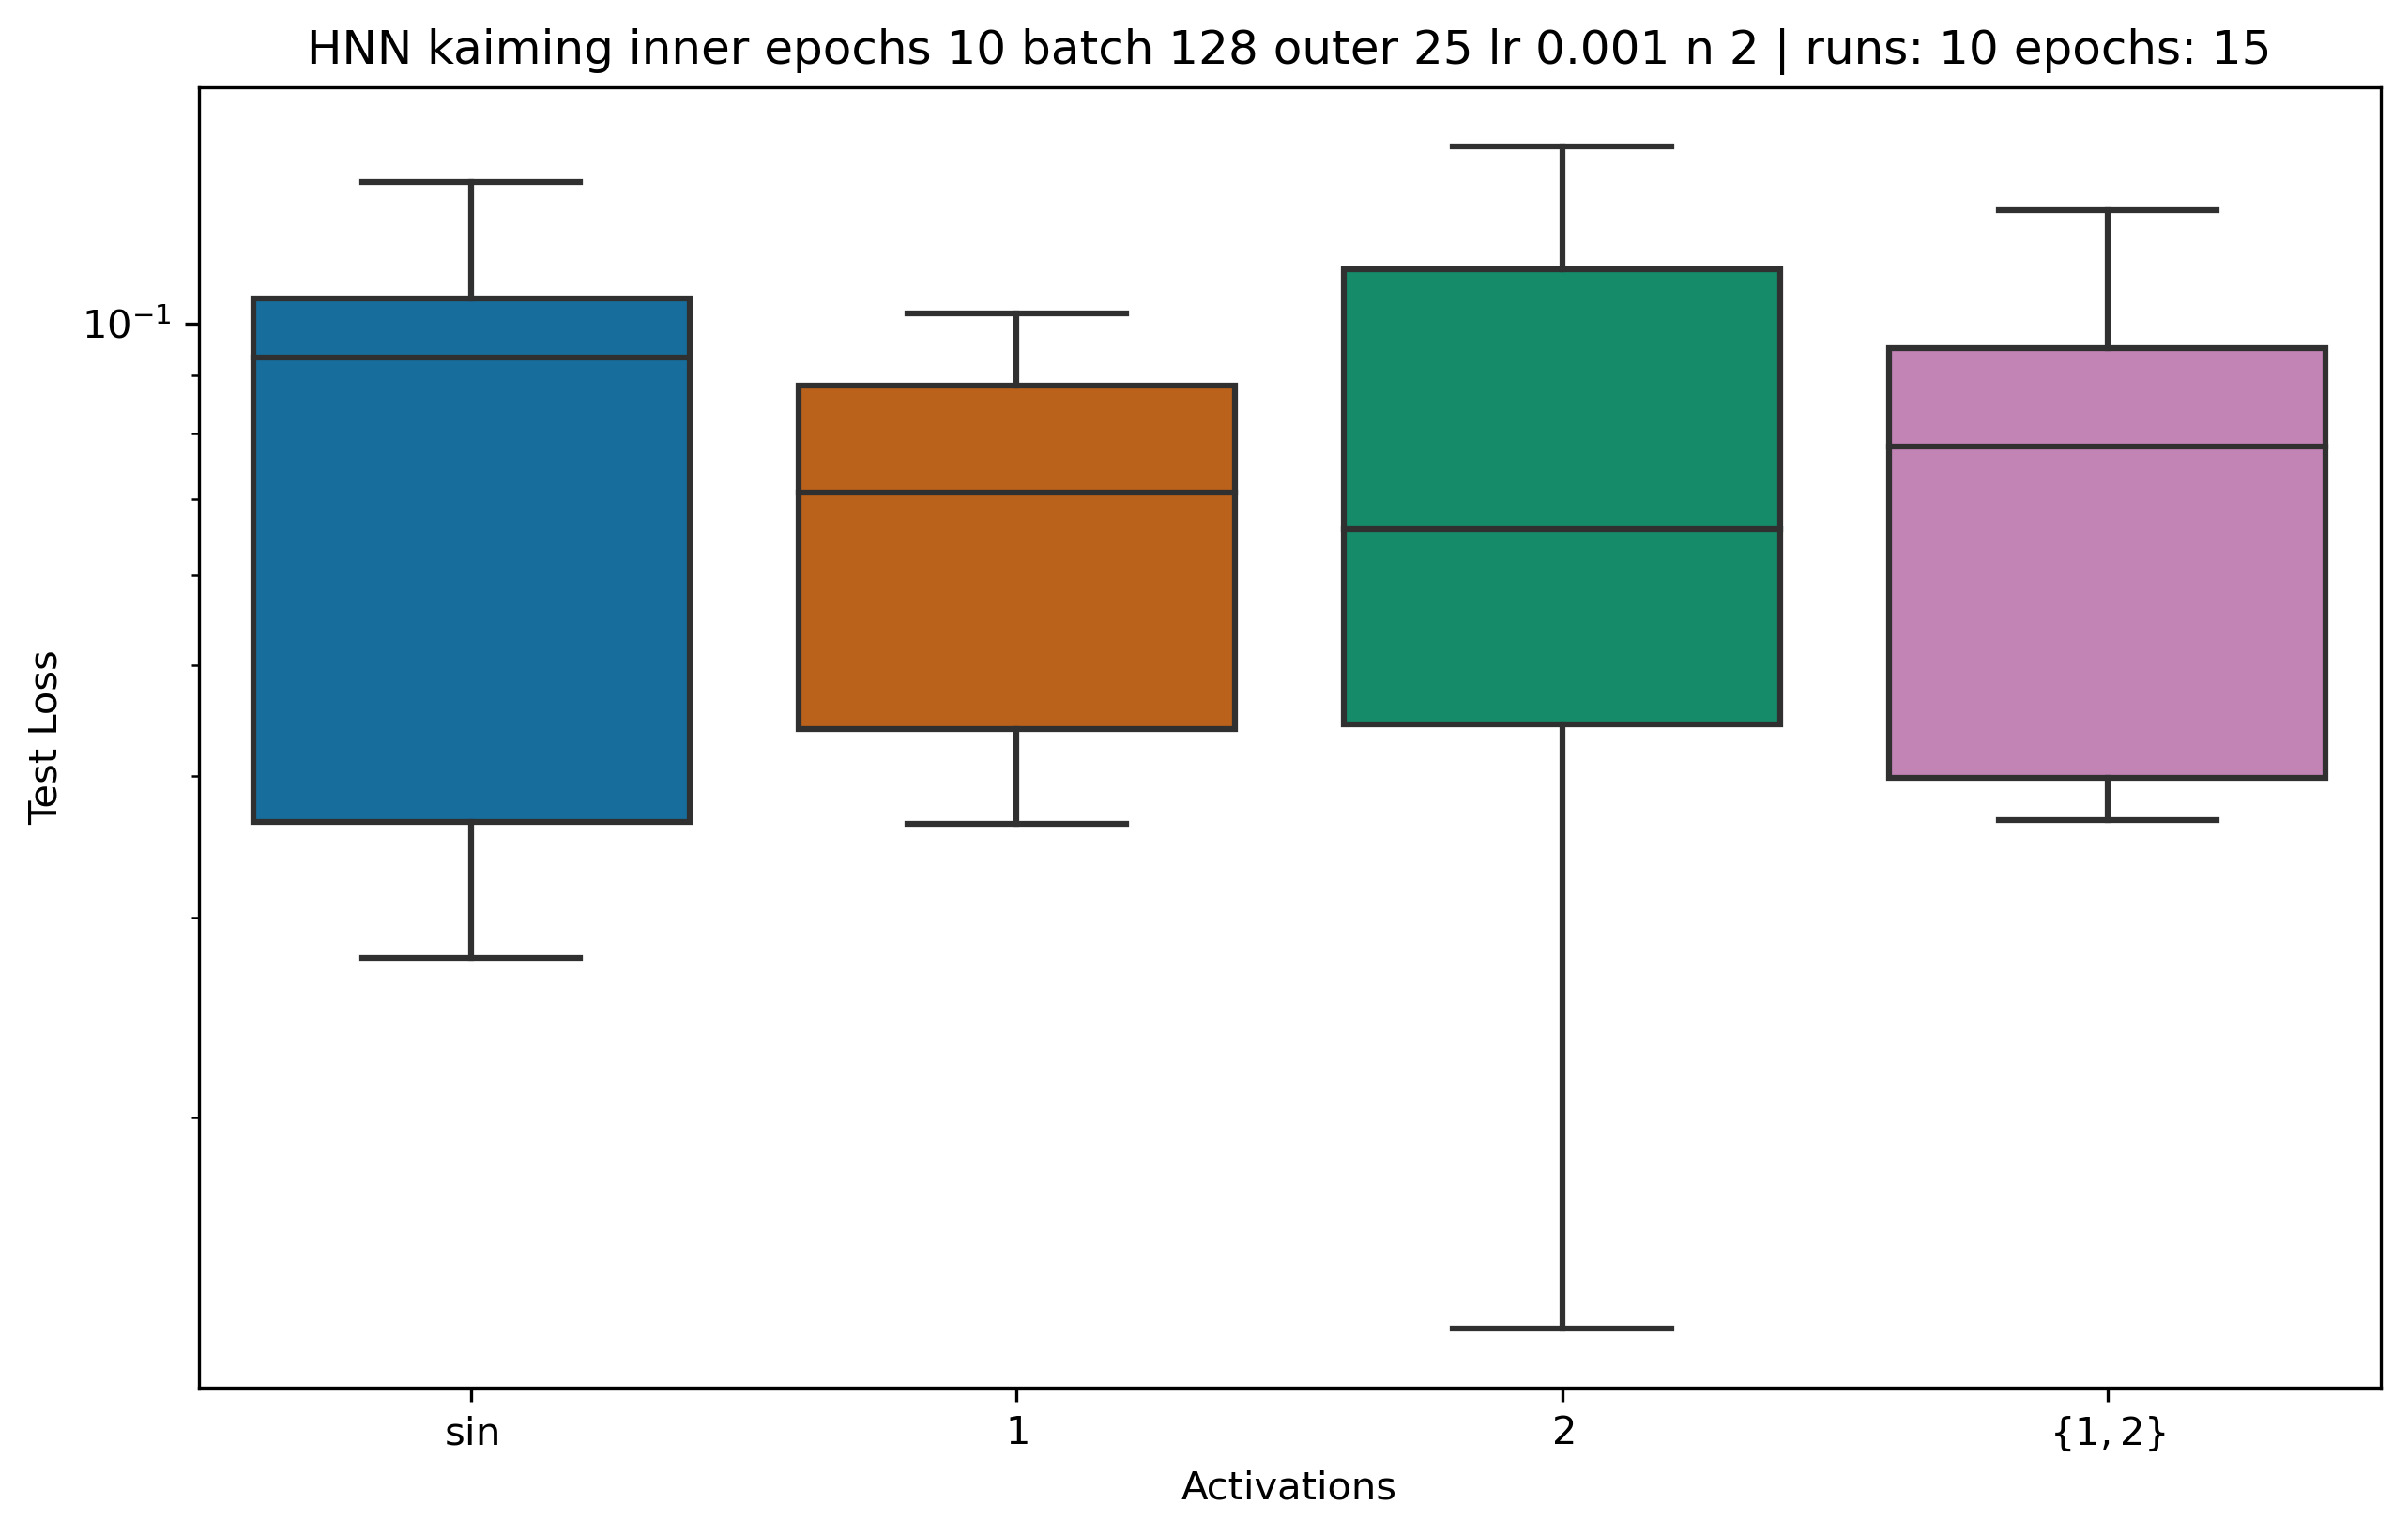

In [ ]:
# boxplot using seaborn
plt.style.use("default")
# sns.set_theme(context='paper', style='dark', palette='colorblind', font_scale=1, color_codes=True, rc={'text.usetex' : True})

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
sns.boxplot(
    data=[act_sin[1][:, -1], act_1[1][:, -1], act_2[1][:, -1], all_acts[1][:, -1]],
    ax=ax,
    palette=["b", "r", "g", "m"],
)
ax.set_yscale("log")
ax.set_xticklabels(["$\sin$", "$1$", "$2$", "$\{1,2\}$"])
ax.set_ylabel("Test Loss")
ax.set_xlabel("Activations")
ax.set_title(
    f"{' '.join(description.split('_')[:-2])} "
    + f"| runs: {runs} epochs: {config.epochs}"
)
plt.savefig(f"{fig_path}/boxplot.png")
plt.savefig(f"{fig_path}/boxplot.pdf")
plt.show()